# <U>Notebook Table Of Contents<u>

**1. Using astroquery to query the SDSS Archive <br>**
&nbsp;&nbsp;&nbsp;&nbsp;1.1 querying SDSS sky server using SQL to obtain SpecIDs<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.2 Using SpecIDs to download the corresponding fits files containing the spectra from the SDSS Science Archive Server<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.3 Reading in the fits file<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.4 sppParams Table<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.5 specObj view<br>
**2. Obtaining sample of stars from SDSS archive for use in project**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 getting max 200 spectra for each MK class<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2 Creating a function to download the fits files<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.3 Downloading fits files relating to spectra IDs stored in all_classes<br>
**3. loading in the SDSS_params data containing the MK classifications for all SDSS spectra in sample**<br>
**4. loading in fits files for processing (data directory: ../data/SDSS_downloads/)**<br>
**5. saving SDSS data**    

- Loading in required astro packages to access SDSS data (may need to pip install before importing):

In [1]:
#pip install astropy

In [3]:
#pip install astroquery

In [4]:
#pip install specutils==1.4

In [2]:
# other standard packages
import requests
from urllib.parse import quote
import os
import pandas as pd
import numpy as np
from collections import Counter
import astropy

#visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

#astro libraries
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import units as u
from astroquery.sdss import SDSS

from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import CubicSpline

- astroquery: https://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html#astroquery.sdss.SDSSClass
- astropy: https://docs.astropy.org/en/stable/io/fits/index.html
- simbad: https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD224930&submit=SIMBAD+search
- https://rishipaudel.wordpress.com/2018/03/07/python-script-to-use-astroquery-to-get-the-information-of-stars-and-other-targets-in-simbad-vizier/ 

--------

# 1. Using astroquery to query the SDSS Archive (https://data.sdss.org/sas/dr18):

### 1.1  querying SDSS sky server using SQL to obtain SpecIDs 

In [5]:
# defining SQL query to send to SDSS sky server
query = """
SELECT TOP 100 
    s.specObjID, 
    s.z,
    s.plate,
    s.mjd,
    s.fiberID,
    s.class,
    s.subClass
FROM
    SpecObj AS s
WHERE
    instrument LIKE "SDSS"
    AND s.class = 'STAR'
    AND s.zWarning = 0
    AND s.sciencePrimary = 1
    AND s.z BETWEEN -0.001 AND 0.001
ORDER BY
    s.snMedian_r DESC
"""

- the SpecObj view, which contains data for only those fibers defined as sciencePrimary - essentially, the best spectrum that the SDSS has obtained for that object. That is, specObj contains no duplicate observations.

ref: https://www.sdss4.org/dr17/help/faq/#scienceprimary

- This view includes only those objects from SpecObjAll that have clean spectra. The view excludes QA and Sky and duplicates. Use this as the main way to access the spectroscopic objects.

ref:https://skyserver.sdss.org/dr7/en/help/docs/tabledesc.asp

-note:  A view is a virtual table used to view or manipulate some parts of the table

In [6]:
#running query against SDSS sky server
res = SDSS.query_sql(query)
print(res[:5])

     specObjID            z       plate  mjd  fiberID class subClass
------------------- ------------- ----- ----- ------- ----- --------
3176200544544988160 -0.0001457608  2821 54393     134  STAR       F9
3521863916999254016 -0.0002128853  3128 54776     178  STAR       G2
3521951603051569152 -3.448412e-05  3128 54776     497  STAR       F9
3521916693557387264 -0.0005539117  3128 54776     370  STAR       G2
3506094446305452032  0.0001263502  3114 54773     153  STAR       G2


In [7]:
#looking up example spec_ID to see if I can download a spectrum directly to python as well as 
spec_obj_id = res['specObjID'][0]

In [8]:
spec_obj_id

3176200544544988160

### 1.2  Using SpecIDs to download the corresponding fits files containing the spectra from the SDSS Science Archive Server
- https://data.sdss.org/sas/
- https://www.sdss.org/dr18/data_access/get_data/
- SDSS spectrum identifiers: 
    https://www.sdss4.org/dr17/spectro/spectro_basics/#:~:text=SDSS%20Spectrum%20Identifiers,will%20have%20different%20MJD%20values

In [9]:
#defining directoy where all fits download files should go
sdss_data_directory = "../data/SDSS_downloads"

In [10]:
#base url for data release 18 from Science Archive Server
base_url = "https://data.sdss.org/sas/dr18/spectro/sdss/redux/103/spectra/lite/"

#getting the plate number, mjd (modified julian date) and fiberID for that specID
query =  f"SELECT plate, mjd, fiberID FROM specObj WHERE specObjID = {spec_obj_id}"

res = SDSS.query_sql(query)

plate, mjd, fiberID = str(res['plate'][0]), str(res['mjd'][0]), str(res['fiberID'][0])

#creating the fits files download url
spectra_url = f"{base_url}{plate}/spec-{plate}-{mjd}-{fiberID.zfill(4)}.fits"

spectra_response = requests.get(spectra_url)

In [11]:
spectra_url

'https://data.sdss.org/sas/dr18/spectro/sdss/redux/103/spectra/lite/2821/spec-2821-54393-0134.fits'

In [12]:
file_name = str(spec_obj_id)+".fits"
file_path = sdss_data_directory+"/"+file_name
with open(file_path, 'wb') as file:
            file.write(spectra_response.content)

In [13]:
if spectra_response.status_code == 200:
        file_name = str(spec_obj_id)+".fits"
        file_path = sdss_data_directory+"/"+file_name
        with open(file_path, 'wb') as file:
            file.write(spectra_response.content)
        print(f"Finished saving specID:{spec_obj_id} to {sdss_data_directory}/{file_name}")
else:
        print("Error downloading file")

Finished saving specID:3176200544544988160 to ../data/SDSS_downloads/3176200544544988160.fits


### 1.3 Reading in the fits file

In [15]:
# Load the FITS file
fits_file = fits.open('../data/SDSS_downloads/3176200544544988160.fits')

In [16]:
fits_file.info()

Filename: ../data/SDSS_downloads/3176200544544988160.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     168   ()      
  1  COADD         1 BinTableHDU     26   3830R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


In [17]:
#fits_file[0].header

In [18]:
df = pd.DataFrame(fits_file[1].data)

In [19]:
df.head()

,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,170.772720,3.5802,0.083906,0,234881024,1.246723,5.028944,169.888092
1,172.381149,3.5803,0.153617,0,236716032,1.258214,8.362691,176.706955
2,170.031311,3.5804,0.158816,0,203161600,1.257712,8.327000,164.412140
3,158.794144,3.5805,0.172208,0,201326592,1.258246,8.300947,158.247757
4,149.621048,3.5806,0.197567,0,201326592,1.257840,7.892663,152.638519


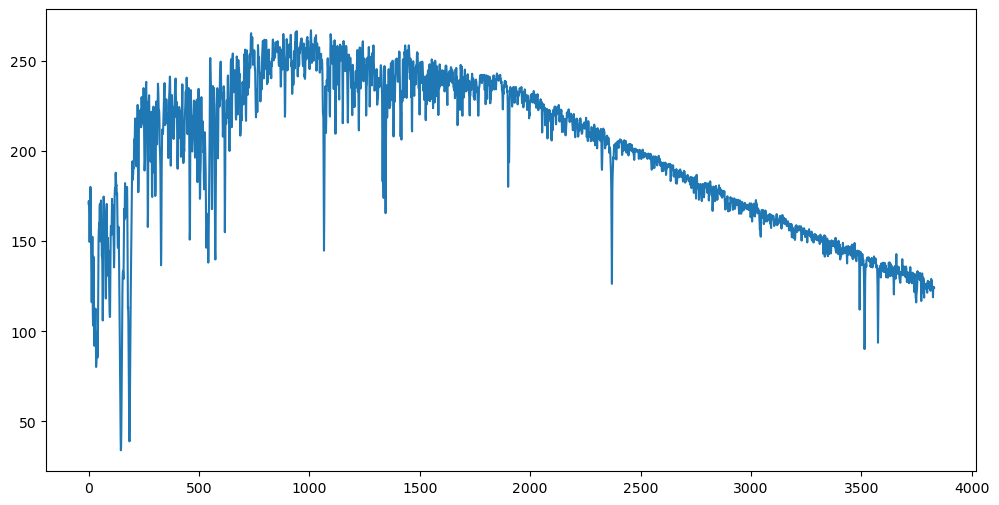

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df['flux'])

---------
### Looking at the derived spectra parameters from some tables available on the SDSS server
- These parameters will provide the labelled information relating to the star measured in the corresponding spectra. Therefore allowing the spectral class to be obtained.

### 1.4 sppParams Table
- schema ref: https://skyserver.sdss.org/dr18/MoreTools/browser?table=sppParams&id=1237656241700470810&spec=&apid=&fieldId=0x112d09cb609a0000&ra=340.011667132273&dec=13.4156426755101&plateId=3521814988731817984&mangaid=

- methods used: https://www.sdss4.org/dr17/spectro/sspp_methods/


In [21]:
spp_query_1 = """
    SELECT
        SPECOBJID,
        SPECTYPEHAMMER,
        SPECTYPESUBCLASS,
        TEFFADOP,
        LOGGADOP,
        FEHADOP,
        SNR,
        TEFFSPEC,
        LOGGSPEC,
        FEHSPEC
    FROM
        sppParams
    WHERE
        SPECOBJID = 3176200544544988160 
    """

In [22]:
SDSS.query_sql(spp_query_1)

SPECOBJID,SPECTYPEHAMMER,SPECTYPESUBCLASS,TEFFADOP,LOGGADOP,FEHADOP,SNR,TEFFSPEC,LOGGSPEC,FEHSPEC
int64,str2,str2,float64,float64,float64,float64,float64,float64,float64
3176200544544988160,G6,F9,5999.261,4.1285,-0.1768937,131.3599,5984.849,4.1285,-0.1849758


### 1.5 specObj view 

-ref https://skyserver.sdss.org/dr18/MoreTools/browser/

contraints: 
- Class is a "Star"; only interested in stars for this project
- zWarning = 0; Bitmask of warning values; 0 means all is well.
- sciencePrimary = 1 ; This flag indicates that the object is a primary observation. i.e. Best version of spectrum at this location
- z Between -0.0001 AND 0.001; filtering out values with a substantial redshift value, meaning they are outside the Milky Way. 

In [23]:
spobj_query = """
SELECT 
    specObjID, 
    instrument,
    survey,
    plate,
    mjd,
    fiberID,
    class,
    subClass,
    z,
    elodieSpType,
    elodieTEff,
    elodieLogG,
    elodieFeH,
    snMedian,
    snMedian_r, 
    programname
FROM
    SpecObj
WHERE
    specObjID = 3176200544544988160
"""

In [24]:
SDSS.query_sql(spobj_query)

specObjID,instrument,survey,plate,mjd,fiberID,class,subClass,z,elodieSpType,elodieTEff,elodieLogG,elodieFeH,snMedian,snMedian_r,programname
uint64,str4,str6,int64,int64,int64,str4,str2,float64,str2,int64,float64,float64,float64,float64,str11
3176200544544988160,SDSS,segue1,2821,54393,134,STAR,F9,-0.0001457608,G0,5671,4.323,-0.18,129.4651,135.2801,segclusterf


In [39]:
spobj_query = """
SELECT TOP 10
    specObjID,
    plate,
    mjd,
    fiberID,
    class,
    subClass,
    z,
    elodieObject,
    elodieSpType,
    snMedian,
    snMedian_r, 
    programname
FROM
    SpecObj
WHERE
    instrument LIKE "SDSS"
    AND class = 'STAR'
    AND zWarning = 0
    AND sciencePrimary = 1
    AND z BETWEEN -0.001 AND 0.001 
    AND NOT elodieSpType LIKE "unknown"
    AND snMedian_r > 50
"""

In [40]:
specObj = SDSS.query_sql(spobj_query)

In [41]:
type(specObj)

astropy.table.table.Table

In [42]:
specObj_df = specObj.to_pandas()

In [43]:
specObj_df = specObj_df.sort_values('specObjID')

In [44]:
specObj_df.head()

,specObjID,plate,mjd,fiberID,class,subClass,z,elodieObject,elodieSpType,snMedian,snMedian_r,programname
0,1348859194379364352,1198,52669,113,STAR,F9,-0.000093,HD089269,G5,47.03063,51.11653,legacy
1,3496090815510454272,3105,54825,624,STAR,F9,-0.000127,HD065583,G8V,42.36523,51.24204,segue2
2,3496091915022082048,3105,54825,628,STAR,K1,0.000041,HD190404,K1V,58.07087,67.20229,segue2
3,3496092189899988992,3105,54825,629,STAR,K1,-0.000418,HD041597,G8III,49.06227,60.49478,segue2
4,3496093014533709824,3105,54825,632,STAR,K5,-0.000042,HD201091,K5V,38.58515,50.89717,segue2


In [46]:
specObj_df['programname']

0    legacy
1    segue2
2    segue2
3    segue2
4    segue2
5    segue2
6    segue2
7    segue2
8    segue2
9    segue2
Name: programname, dtype: object

In [47]:
spec_id_list = list(specObj_df['specObjID'])
#spec_id_list

In [48]:
spec_id_list = ', '.join(map(str, spec_id_list))
spec_id_list

'1348859194379364352, 3496090815510454272, 3496091915022082048, 3496092189899988992, 3496093014533709824, 3496095213556965376, 3497045465021652992, 3497045739899559936, 3497047664044908544, 3497048488678629376'

In [49]:
spp_query = f"""
    SELECT
        SPECOBJID,
        SPECTYPEHAMMER,
        SPECTYPESUBCLASS,
        TEFFADOP,
        LOGGADOP,
        FEHADOP,
        SNR,
        TEFFSPEC,
        LOGGSPEC,
        FEHSPEC
    FROM
        sppParams
    WHERE
        SPECOBJID IN ({spec_id_list})
    """

In [50]:
sppParams_table = SDSS.query_sql(spp_query)

In [51]:
sppParams_table

SPECOBJID,SPECTYPEHAMMER,SPECTYPESUBCLASS,TEFFADOP,LOGGADOP,FEHADOP,SNR,TEFFSPEC,LOGGSPEC,FEHSPEC
int64,str2,str2,float64,float64,float64,float64,float64,float64,float64
1348859194379364352,K0,F9,5748.288,4.046039,-0.3078997,47.62643,5684.295,4.046039,-0.3842352
3496090815510454272,K2,F9,5235.234,4.403043,-0.9239684,42.48384,5227.311,4.403043,-1.004629
3496091915022082048,K2,K1,5129.916,4.315231,-0.788039,58.77768,5145.056,4.315231,-0.7496986
3496092189899988992,K2,K1,4781.436,2.155421,-0.5839133,49.8513,4846.947,2.155421,-0.5183501
3496093014533709824,K4,K5,4339.932,4.053323,-0.733559,39.50383,4392.775,4.053323,-0.8824188
3496095213556965376,G4,G2,5950.858,3.974072,-0.4793217,64.06458,5921.356,3.974072,-0.4718958
3497045465021652992,K2,K3,4831.564,4.874279,-1.108796,60.6605,4823.565,4.874279,-1.108796
3497045739899559936,K4,K3,4695.243,4.442525,-0.1966542,56.69116,4718.774,4.442525,-0.2001596
3497047664044908544,K0,F9,5435.346,4.486588,-0.846386,53.99283,5460.584,4.486588,-0.821489


In [52]:
sppParams_df = sppParams_table.to_pandas()

In [53]:
sppParams_df = sppParams_df.sort_values('SPECOBJID')

In [54]:
sppParams_df.head()

,SPECOBJID,SPECTYPEHAMMER,SPECTYPESUBCLASS,TEFFADOP,LOGGADOP,FEHADOP,SNR,TEFFSPEC,LOGGSPEC,FEHSPEC
0,1348859194379364352,K0,F9,5748.288,4.046039,-0.307900,47.62643,5684.295,4.046039,-0.384235
1,3496090815510454272,K2,F9,5235.234,4.403043,-0.923968,42.48384,5227.311,4.403043,-1.004629
2,3496091915022082048,K2,K1,5129.916,4.315231,-0.788039,58.77768,5145.056,4.315231,-0.749699
3,3496092189899988992,K2,K1,4781.436,2.155421,-0.583913,49.85130,4846.947,2.155421,-0.518350
4,3496093014533709824,K4,K5,4339.932,4.053323,-0.733559,39.50383,4392.775,4.053323,-0.882419


In [55]:
## Looking at two key dataframes for the 10 specID's

In [56]:
specObj_df.head()

,specObjID,plate,mjd,fiberID,class,subClass,z,elodieObject,elodieSpType,snMedian,snMedian_r,programname
0,1348859194379364352,1198,52669,113,STAR,F9,-0.000093,HD089269,G5,47.03063,51.11653,legacy
1,3496090815510454272,3105,54825,624,STAR,F9,-0.000127,HD065583,G8V,42.36523,51.24204,segue2
2,3496091915022082048,3105,54825,628,STAR,K1,0.000041,HD190404,K1V,58.07087,67.20229,segue2
3,3496092189899988992,3105,54825,629,STAR,K1,-0.000418,HD041597,G8III,49.06227,60.49478,segue2
4,3496093014533709824,3105,54825,632,STAR,K5,-0.000042,HD201091,K5V,38.58515,50.89717,segue2


In [57]:
sppParams_df.head()

,SPECOBJID,SPECTYPEHAMMER,SPECTYPESUBCLASS,TEFFADOP,LOGGADOP,FEHADOP,SNR,TEFFSPEC,LOGGSPEC,FEHSPEC
0,1348859194379364352,K0,F9,5748.288,4.046039,-0.307900,47.62643,5684.295,4.046039,-0.384235
1,3496090815510454272,K2,F9,5235.234,4.403043,-0.923968,42.48384,5227.311,4.403043,-1.004629
2,3496091915022082048,K2,K1,5129.916,4.315231,-0.788039,58.77768,5145.056,4.315231,-0.749699
3,3496092189899988992,K2,K1,4781.436,2.155421,-0.583913,49.85130,4846.947,2.155421,-0.518350
4,3496093014533709824,K4,K5,4339.932,4.053323,-0.733559,39.50383,4392.775,4.053323,-0.882419


-------

# 2. Obtaining sample of stars from SDSS archive for use in project:

##### The below section of code defines a function that will be utilised to load in the stellar parameters directly from SDSS


**Selected columns:**
- SpecObjID: unique ID of the spectrum.
- plate, mjd, fiberID: provide information on the plate number, mean julian date of data collection, and fiberID. These three are required for fetching the fits file from the system archive server (SAS). 
- Z:  redshift of the object.
- snMedian: signal to noise ratio of the spectrum
- sciencePrimary, sdssPrimary, legacyPrimary, seguePrimary, bossPrimary: flags that are also used for determining what subdirectory to query when fetching the fits file. 
- Programme: name of the SDSS program that the object was observed under.<br>

**Where Clause:**<br>
- Class = “Star”: ensures only objects relating to stars are returned (e.g no galaxies) 
- Instrument = ‘SDSS”: only searching for objects detected using SDSS instrument. 
- zWarning = 0: ensures the measurement is reliable and has no warnings associated.
- sciencePrimary = 1: ensures only primary science observations are considered since SDSS      may sometimes take multiple readings for the same object. This ensures only most reliable is used. 
- Z Between -0.001 AND 0.001: ensures no redshift, therefore only stars within the milky way considered as advised from interviews. 
- sMedian > 40: all observations have a sufficiently high signal to noise (at least 40). 
- NOT programme Like “Reddening”: observations from this programme are excluded as they are observing stars moving away from the observer, resulting in shifted spectra. 
- SPECTYPESUBCLASS LIKE '*MK Class*': used for querying a specific MK subclass. 


In [90]:
#creating a function to query SDSS server with defined constraints

def fetch_SDSS(num_stars= '1000', sp_class='all', snr_thres='50', spec_obj_id='all', elodie_obj_id='all'):
    ##-------------------Building SQL Query---------------------------##
    # limiting the number of stars returned to num_stars argument
    if spec_obj_id == 'all' and elodie_obj_id == 'all':
        select_clause = f"SELECT TOP {num_stars}"
    else:
        select_clause = "SELECT"
    
    #baseline SQL query (TO DO - maybe explain this in more detail)
    sql_query = f"""
                    {select_clause}
                        s.specObjID,
                        s.plate,
                        s.mjd,
                        s.fiberID,
                        s.z,
                        s.snMedian,
                        s.sciencePrimary,
                        s.sdssPrimary, 
                        s.legacyPrimary,
                        s.seguePrimary,
                        s.bossPrimary,
                        s.programname,
                        p.SPECTYPESUBCLASS AS subClass,
                        p.TEFFADOP as TEFFADOP_SPP,
                        p.LOGGADOP as LOGGADOP_SPP,
                        p.FEHADOP as FEHADOP_SPP
                    FROM
                        SpecObj AS s
                    INNER JOIN
                        sppParams AS p
                    ON
                        s.specObjID = p.SPECOBJID
                    WHERE
                        s.class = 'STAR'
                    """
    
    #if all spec IDs selected, the full list of where clauses need to be left in
    if spec_obj_id == 'all' and elodie_obj_id == 'all':
        sql_query +=  f"""
                        AND s.instrument LIKE "SDSS"
                        AND s.zWarning = 0
                        AND s.sciencePrimary = 1
                        AND s.z BETWEEN -0.001 AND 0.001 
                        AND s.snMedian_r > {snr_thres}
                        AND NOT s.programname LIKE "reddening"
                        """
    elif spec_obj_id!='all':
        sql_query += f"AND s.specObjID = {spec_obj_id}"
        
    elif elodie_obj_id!='all':
        sql_query += f"AND s.elodieObject = {elodie_obj_id}"
        
    elif spec_obj_id!='all' and elodie_obj_id!='all':
        sql_query += f"AND s.elodieObject = {elodie_obj_id} AND s.specObjID = {spec_obj_id}"
    
        
    #if a specific spectral class is defined then need to include this in the where clause
    if sp_class != 'all':
        sql_query += " AND p.SPECTYPESUBCLASS LIKE '{}%'".format(sp_class)
        
    ##===============running query for SpecObj table================##
    
    stellar_params = SDSS.query_sql(sql_query)
    stellar_params_df = stellar_params.to_pandas()
    stellar_params_df = stellar_params_df.sort_values('specObjID')
    stellar_params_df = stellar_params_df.reset_index().drop(columns='index')
    return  stellar_params_df

In [91]:
#running the function for all default params: 
#i.e. (num_stars= '100', sp_class='all', snr_thres='50', spec_obj_id='all', elodie_obj_id='all')
sdss_data_1 = fetch_SDSS()
sdss_data_1.head()

,specObjID,plate,mjd,fiberID,subClass,z,snMedian,sciencePrimary,sdssPrimary,legacyPrimary,seguePrimary,bossPrimary,programname,TEFFADOP_SPP,LOGGADOP_SPP,FEHADOP_SPP
0,300656533790812160,267,51608,150,G2,0.000360,44.56562,1,1,1,0,0,legacy,5895.325,4.151120,-0.598305
1,300699964500109312,267,51608,308,G0,-0.000098,51.28839,1,1,1,0,0,legacy,6025.445,3.918378,-0.564743
2,301835760431032320,268,51633,344,G2,0.000179,58.45531,1,1,1,0,0,legacy,5822.880,3.883754,-0.409347
3,302946821578188800,269,51910,290,F9,-0.000073,51.63845,1,1,1,0,0,legacy,5708.933,4.297188,-0.265677
4,305206867276097536,271,51883,320,G2,0.000263,52.20524,1,1,1,0,0,legacy,5921.471,4.118198,-0.492100


## 2.1 getting max 200 spectra for each MK class

In [92]:
#getting samples for each MK main class (ignoring subclasses for now)..
#setting signal to noise ratio threshold to 20 to include more samples
#getting maximum 200 stars for each class

class_O = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='O')
class_B = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='B')
class_A = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='A')
class_F = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='F')
class_G = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='G')
class_K = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='K')
class_M = fetch_SDSS(num_stars= '200', snr_thres='20', sp_class='M')

In [93]:
#adding main class column to dataframes
class_O['mainClass']='O'
class_B['mainClass']='B'
class_A['mainClass']='A'
class_F['mainClass']='F'
class_G['mainClass']='G'
class_K['mainClass']='K'
class_M['mainClass']='M'

In [94]:
#merging all main classes into one dataframe
dataframes = [class_O, class_B, class_A, class_F, class_G, class_K, class_M]
sdss_params = pd.concat(dataframes, ignore_index=True)
sdss_params = sdss_params.reset_index().drop(columns='index')
sdss_params.head()

,specObjID,plate,mjd,fiberID,subClass,z,snMedian,sciencePrimary,sdssPrimary,legacyPrimary,seguePrimary,bossPrimary,programname,TEFFADOP_SPP,LOGGADOP_SPP,FEHADOP_SPP,mainClass
0,1846635614334642176,1640,53758,581,O,0.000203,38.89043,1,1,0,0,0,taurus,6655.834,3.562952,-0.724957,O
1,1846638088235804672,1640,53758,590,O,0.000123,27.32537,1,1,0,0,0,taurus,6832.885,4.390036,-0.161618,O
2,3116618831921965056,2768,54265,465,O,0.000115,42.14191,1,1,1,0,0,legacy,6016.578,2.483981,-3.826766,O
3,330028339018360832,293,51689,508,B9,0.000227,50.19657,1,1,1,0,0,legacy,7437.497,4.110709,-2.389009,B
4,665534147338463232,591,52022,463,B9,-0.000197,55.78799,1,1,1,0,0,legacy,7657.726,4.230442,-2.260580,B


Text(0.5, 1.0, 'count plot: number of stars in each class returned from SDSS query')

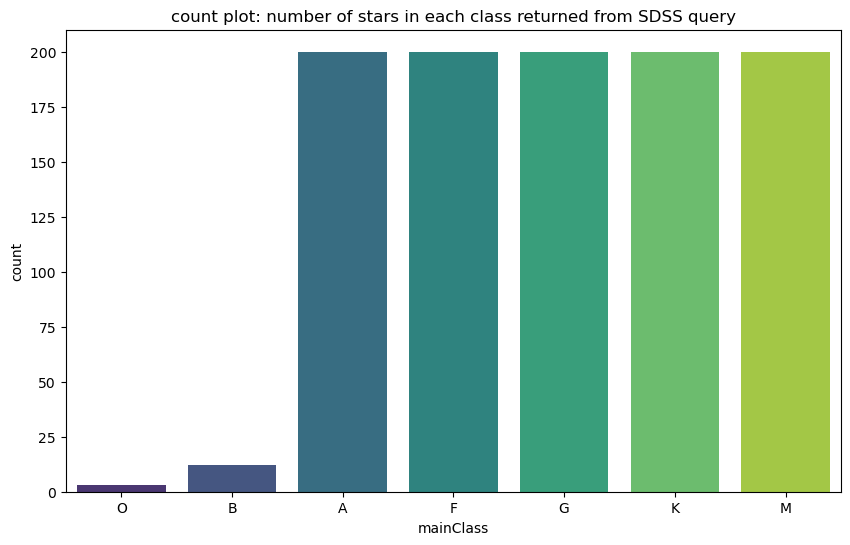

In [96]:
plt.figure(figsize=(10, 6))
sns.countplot(x='mainClass', data=sdss_params, palette='viridis')
plt.title('count plot: number of stars in each class returned from SDSS query')

In [101]:
sdss_params.rename(columns={'TEFFADOP_SPP':'TEff','LOGGADOP_SPP':'LogG','FEHADOP_SPP':'metalicity'})
sdss_params.columns = sdss_params.columns.str.lower()
sdss_params.head()

,specobjid,plate,mjd,fiberid,subclass,z,snmedian,scienceprimary,sdssprimary,legacyprimary,segueprimary,bossprimary,programname,teffadop_spp,loggadop_spp,fehadop_spp,mainclass
0,1846635614334642176,1640,53758,581,O,0.000203,38.89043,1,1,0,0,0,taurus,6655.834,3.562952,-0.724957,O
1,1846638088235804672,1640,53758,590,O,0.000123,27.32537,1,1,0,0,0,taurus,6832.885,4.390036,-0.161618,O
2,3116618831921965056,2768,54265,465,O,0.000115,42.14191,1,1,1,0,0,legacy,6016.578,2.483981,-3.826766,O
3,330028339018360832,293,51689,508,B9,0.000227,50.19657,1,1,1,0,0,legacy,7437.497,4.110709,-2.389009,B
4,665534147338463232,591,52022,463,B9,-0.000197,55.78799,1,1,1,0,0,legacy,7657.726,4.230442,-2.260580,B


In [102]:
#checking all specobjid are unique
sdss_params['specobjid'].nunique()

1015

In [103]:
Counter(sdss_params['mainclass'])

Counter({'O': 3, 'B': 12, 'A': 200, 'F': 200, 'G': 200, 'K': 200, 'M': 200})

In [104]:
#save to csv to be loaded into modelling notebooks
sdss_params.to_csv('../data/derived_tables/SDSS_params.csv')

#### about base urls for each spectra: 

- eBOSS, BOSS and SEQUELS spectra: https://dr18.sdss.org/sas/dr18/prior-surveys/sdss4-dr17-eboss/spectro/redux/v5_13_2/spectra/
- SDSS Legacy spectra: https://dr18.sdss.org/sas/dr18/prior-surveys/sdss2-dr8-sdss/spectro/redux/26/spectra/
- SDSS stellar cluster plates: https://dr18.sdss.org/sas/dr18/prior-surveys/sdss2-dr8-sdss/spectro/redux/103/spectra/
- SDSS SEGUE-2 plates: https://dr18.sdss.org/sas/dr18/prior-surveys/sdss2-dr8-sdss/spectro/redux/104/spectra/

ref:https://www.sdss.org/dr18/data_access/get_data/

--------
## 2.2 Creating a function to download the fits files

In [151]:
#creating function to download the fits file with specified specObjID
def download_fits(specObjID, data_directory, spectra_params):
    #only looking at spectra params for specObjID
    spectra_params = spectra_params[spectra_params['specobjid']==specObjID]
    
    #base url for data release 18 from Science Archive Server
    base_url = "https://data.sdss.org/sas/dr18/spectro/sdss/redux/"
    
    #getting the rest of the base url depending on the spectral parameters (see markdown above for context)
    if spectra_params['plate'].values[0] in [2800, 2821, 2887 ,2912, 2476, 1961]:
        base_url = base_url + "103/spectra/lite/"
    elif spectra_params['plate'].values[0] in [3110, 3123, 3151, 3300]:
        base_url = base_url + "104/spectra/lite/"
    elif (spectra_params['legacyprimary'].values[0] == 1) or (spectra_params['sdssprimary'].values[0] == 1):
        base_url = base_url + "26/spectra/lite/"
    elif spectra_params['segueprimary'].values[0] == 1: 
        base_url = base_url + "104/spectra/lite/"
    elif spectra_params['bossprimary'].values[0] == 1:
        base_url = base_url + "v5_13_2/spectra/lite/"
    elif 266 < spectra_params['plate'].values[0] < 2973:
        base_url = base_url + "26/spectra/lite/"
    else: 
        base_url = base_url + "v5_13_2/spectra/lite/"

    #getting the plate, mjd (modified julain date), and fiberID to construct the fits file name
    #i.e. naming convention of each file is "**plate**-**mjd**-**fiberId**.fits"
    plate, mjd, fiberID = str(spectra_params['plate'].values[0]), str(spectra_params['mjd'].values[0]), \
                          str(spectra_params['fiberid'].values[0])
    
    #updating plate and fiberID to always have at least 4 digits (i.e 123 will be 0123) to align with directory format
    if(len(plate) < 4):
        plate = plate.zfill(4)

    if(len(fiberID) < 4):
        fiberID = fiberID.zfill(4)

    #defining the final url to download the file from 
    spectra_url = f"{base_url}{plate}/spec-{plate}-{mjd}-{fiberID}.fits"
    
    #sending request to fits url from SDSS SAS
    spectra_response = requests.get(spectra_url)
    
    #if no issues with response, the file is written to the defined file path
    if spectra_response.status_code == 200:
        file_name = str(specObjID)+".fits"
        file_path = data_directory+"/"+file_name
        with open(file_path, 'wb') as file:
            file.write(spectra_response.content)
        print(f"Finished saving specID:{specObjID} to {data_directory}/{file_name}")
    else:
        print(f"Error downloading file: {file_name}")

## 2.3 Downloading fits files relating to spectra IDs stored in all_classes

In [107]:
specobjid_list = list(sdss_params['specobjid'])
#specobjid_list

In [161]:
spectra_params = sdss_params[['specobjid','plate','mjd','fiberid',
                               'scienceprimary', 'sdssprimary', 'legacyprimary',
                               'segueprimary', 'bossprimary', 'programname']]

In [162]:
spectra_params.head()

,specobjid,plate,mjd,fiberid,scienceprimary,sdssprimary,legacyprimary,segueprimary,bossprimary,programname
0,1846635614334642176,1640,53758,581,1,1,0,0,0,taurus
1,1846638088235804672,1640,53758,590,1,1,0,0,0,taurus
2,3116618831921965056,2768,54265,465,1,1,1,0,0,legacy
3,330028339018360832,293,51689,508,1,1,1,0,0,legacy
4,665534147338463232,591,52022,463,1,1,1,0,0,legacy


In [163]:
spectra_params.to_csv('../data/derived_tables/sdss_spectra_params')

In [183]:
#defining directoy where all fits download files should go
sdss_data_directory = "../data/SDSS_downloads"

In [153]:
#downloading the fits files from SDSS SAS for all specobjids listed in selected_classes table
#download_fits(specObjIsD, data_directory, spectra_params)

for objid in specobjid_list[]:
    download_fits(objid, sdss_data_directory, spectra_params)

## 3. loading in the SDSS_params data containing the MK classifications for all SDSS spectra in sample

In [4]:
#loading in stellar parameters tables
stellar_params = pd.read_csv('../data/derived_tables/SDSS_params.csv',index_col=0)

In [5]:
stellar_params = stellar_params[['specobjid', 'snmedian', 'subclass', 'mainclass', 'programname']]

In [6]:
stellar_params.set_index('specobjid', inplace=True)

## 4. loading in fits files for processing (data directory: ../data/SDSS_downloads/) 

### 4.1 loading in one file to see structure of fits file
- details on contents of spectra fits files found here: https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html
- more notes related to reading indivual spectra detailed here: https://classic.sdss.org/dr7/products/spectra/read_spSpec.php

Notable values from fits file: <br> 
    a) flux - float32 - coadded calibrated flux [10-17 ergs/s/cm2/Å] <br>
    b) loglam - float32 - log10(wavelength [Å])

In [7]:
#Load the FITS file
fits_file = fits.open('../data/SDSS_downloads/1408593192164550656.fits')

In [8]:
specdata = fits_file[1].data
specdata

FITS_rec([(42.854904, 3.5822, 0.12001086, 0, 0, 1.0705004 , 5.5496025, 45.24885 ),
          (41.642303, 3.5823, 0.17660877, 0, 0, 1.0703171 , 5.9202566, 44.18094 ),
          (44.58683 , 3.5824, 0.17282312, 0, 0, 1.0700682 , 5.6709895, 44.901665),
          ...,
          (52.72301 , 3.9638, 0.2832622 , 0, 0, 0.7807632 , 2.7329836, 51.704906),
          (51.16605 , 3.9639, 0.2940648 , 0, 0, 0.78120637, 2.8750105, 51.331543),
          (48.975273, 3.964 , 0.301972  , 0, 0, 0.7816532 , 3.1146946, 51.884888)],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

In [9]:
pd.DataFrame(fits_file[1].data)

,flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
0,42.854904,3.5822,0.120011,0,0,1.070500,5.549603,45.248852
1,41.642303,3.5823,0.176609,0,0,1.070317,5.920257,44.180939
2,44.586830,3.5824,0.172823,0,0,1.070068,5.670990,44.901665
3,47.168976,3.5825,0.167562,0,0,1.069825,5.427938,44.684765
4,42.145599,3.5826,0.179377,0,0,1.069579,5.100864,41.560944
...,...,...,...,...,...,...,...,...
3814,53.450115,3.9636,0.278852,0,0,0.779859,2.649908,51.491024
3815,50.089043,3.9637,0.293424,0,0,0.780318,2.638732,51.612938
3816,52.723011,3.9638,0.283262,0,0,0.780763,2.732984,51.704906
3817,51.166050,3.9639,0.294065,0,0,0.781206,2.875010,51.331543


In [10]:
#converting the wavelength to Angstroms (standard unit of measurments)
wavelength = 10**specdata['loglam'] * u.AA 
wavelength

<Quantity [3821.2024, 3822.0815, 3822.963 , ..., 9200.257 , 9202.379 ,
           9204.495 ] Angstrom>

In [11]:
#getting the flux
# flux refers to the amount of radiant energy (such as light) passing through a unit area per unit time. 
# It is often measured in units like ergs per second per square centimeter (erg/s/cm²) in cgs units
flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
flux

<Quantity [4.2854904e-16, 4.1642302e-16, 4.4586830e-16, ..., 5.2723010e-16,
           5.1166047e-16, 4.8975270e-16] erg / (Angstrom s cm2)>

In [12]:
spectra_vecs = pd.DataFrame({'wavelength':wavelength,'flux':flux})
spectra_vecs.head()

,wavelength,flux
0,3821.202393,4.285490e-16
1,3822.081543,4.164230e-16
2,3822.962891,4.458683e-16
3,3823.842285,4.716897e-16
4,3824.724121,4.214560e-16


In [13]:
stellar_params.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 1846635614334642176 to 3715583299599572992
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   snmedian     1015 non-null   float64
 1   subclass     1015 non-null   object 
 2   mainclass    1015 non-null   object 
 3   programname  1015 non-null   object 
dtypes: float64(1), object(3)
memory usage: 39.6+ KB


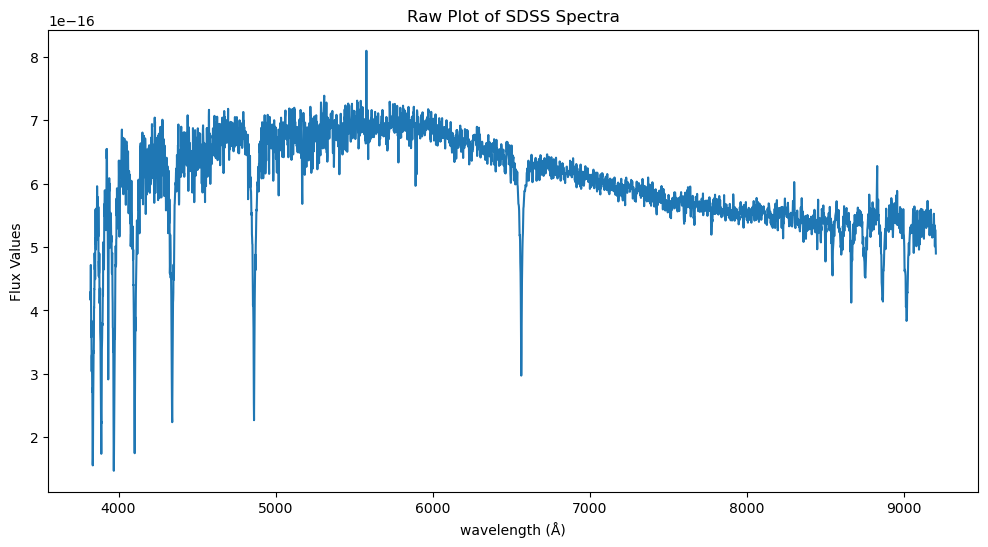

In [15]:
#plotting the spectrum of one star from the SDSS dataset
plt.figure(figsize=(12,6))
plt.title('Raw Plot of SDSS Spectra')
plt.plot(spectra_vecs['wavelength'], spectra_vecs['flux'])
plt.xlabel('wavelength (Å)')
flux_units= u.Unit('erg cm-2 s-1 AA-1')
plt.ylabel('Flux Values')
plt.show()

--------

### 4.2 Processing all spectra files

-notes on spectra: https://www.sdss3.org/dr9/spectro/spectro_basics.php

**Loading in the spectra and appending to a dictionary containing the dataframes for each distinct specobjid**

In [19]:
#listing all files in directory
directory = '../data/SDSS_downloads/'

#initialising dictionary to store dataframes
spectra_dataframes = {}
#initialising number of files iterator
i=0
#initialising specID list
specIDs = []

for filename in os.listdir(directory):
    filepath = os.path.join(directory,filename)
    if os.path.isfile(filepath):
        # Load the FITS file
        with fits.open(filepath) as fits_file:
            fits_file = fits.open(filepath)

            #get the spectra data
            specdata = fits_file[1].data

            #converting wavelength and flux
            wavelength = 10**specdata['loglam'] * u.AA 
            flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
            
            #creating a dataframe containing both wavelength and flux values
            spectra_vecs =  pd.DataFrame({'wavelength':wavelength,'flux':flux}) 
            
            #limiting the wavelength range to be within the optical (3900 - 8000 Angstroms)
            spectra_vecs = spectra_vecs[(spectra_vecs['wavelength']>=3900) 
                                                    & (spectra_vecs['wavelength']<=8000)]
            #resetting index
            spectra_vecs = spectra_vecs.reset_index().drop(columns = ['index'])
            
            #creating a dictionary of dataframes
            spectra_dataframes['df_'+filename[:-5]] = spectra_vecs
            
            #appending specIDs to array
            specIDs.append(filename[:-5])
        i+=1
        
print(f'---------------------------------- \n finished processing {i} files')

---------------------------------- 
 finished processing 1017 files


In [20]:
#checking to ensure there are no duplicate files being processed
print(f'number of files processed: {len(specIDs)}')
print(f'number of unique files: {len(list(set(specIDs)))}')

number of files processed: 1017
number of unique files: 1017


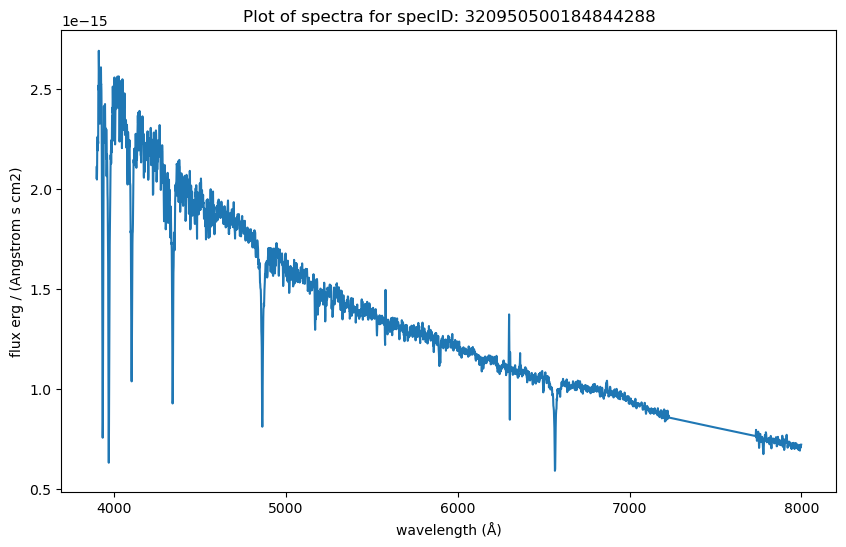

In [21]:
## taking a look at some of the spectra from the dataframes:
plt.figure(figsize=(10,6))
plt.title('Plot of spectra for specID: 320950500184844288')
plt.plot(spectra_dataframes['df_999902510611195904'].wavelength, spectra_dataframes['df_999902510611195904'].flux)
plt.xlabel('wavelength (Å)')
flux_units= u.Unit('erg cm-2 s-1 AA-1')
plt.ylabel(f'flux {flux_units}')
plt.show()

- **Observation**: It is evident from the above visualisation that some of the flux values were interpolated by SDSS in order to produce a continuous spectra. <br>

**Interpolated Flux**
When flux values are interpolated, it means that the actual data in that region were deemed unreliable or were missing, and a mathematical interpolation was used to estimate the flux values based on the surrounding data. This process helps in providing a continuous spectrum but indicates that the data in the greyed out regions are not direct measurements and should be treated with caution. <br>

In SDSS spectra, several flags are used to indicate interpolated data. Some of these flags include:<br>

PSF_FLUX_INTERP: Indicates that the flux values have been interpolated due to problems in the point spread function (PSF) photometry.
INTERP: General flag indicating that the flux values have been interpolated.
INTERP_CENTER: Indicates that the central part of the spectrum was interpolated.
BAD_MOVING_FIT: Suggests that the object’s motion did not fit well, leading to potential interpolation in the affected regions.
Visual Representation<br>
The greyed out areas combined with an interpolated flux line are typically visual cues in SDSS data visualizations to make users aware that those regions should be interpreted with caution. The actual flux values in these areas are estimated and not direct observations.

ref: https://www.sdss3.org/dr9/spectro/spectro_basics.php <br>
https://classic.sdss.org/dr7/products/catalogs/flags.php

- NOTE: Since this interpolation will skew the type of spectra being represented for each spectral class, these will need to be flagged, and potentially removed from being used for training data. 

In [22]:
def check_for_interpolation(spectra_df, spectra_df_name):
    flux_vector = spectra_df.flux
    flux_vector = flux_vector/flux_vector[0]
    wave_vector = list(spectra_df.wavelength)
    
    #creating a blank flag name
    flag = ""
    
    #iterating through the spectrum in buckets of 10 data points
    #checking pearson correlation coefficient, if equal nearly equal to one, this suggests interpolation
    for i in range(5, len(spectra_df)):
        bucket_flux = flux_vector[i-10:i]
        bucket_wave = wave_vector[i-10:i]
        
        corr = np.corrcoef(bucket_wave,bucket_flux)[0][1:][0]
        #if the correlation of the 10 points is nearly one, this suggests interpolation
        if abs(corr) > 0.9999:
            flag = spectra_df_name
    return flag

In [23]:
keys_ = []
for keys, values in spectra_dataframes.items():
    keys_.append(keys)

In [24]:
len(keys_)

1017

In [25]:
flagged_spectra = []

for key,values in spectra_dataframes.items():
    res = check_for_interpolation(spectra_dataframes[key],key)
    if res != '':
        flagged_spectra.append(res)

C:\Users\gerar\anaconda3\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\gerar\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\gerar\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\gerar\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\gerar\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [26]:
#removing flagged spectra for now
print(f'number of spectra before: {len(spectra_dataframes)}')
for dataframe in flagged_spectra:
    del spectra_dataframes[dataframe]
print(f'number of spectra after: {len(spectra_dataframes)}')

number of spectra before: 1017
number of spectra after: 966


### 4.3 Checking all data to ensure flux values all relate to the same wavelengths

In [27]:
#now checking all data to ensure flux values all relate to the same wavelengths
count_list = []
specid_list = []

#getting the counts of each dataframe stored in spectra_dataframes dictionary and storing as array
for key, value in spectra_dataframes.items():
    count_list.append(len(value))
    specid_list.append(key)

## creating a dictionary to identify where there are tables with missing values
#count_dictionary = dict.fromkeys(['count', 'number_of_dataframes', 'spec_ids'], None)
count_dictionary = {'count':[],'number_of_dataframes':[],'spec_ids':[]}

#getting the number of tables with each unique count
for counts in set(count_list):
    #getting indices of dataframe counts 
    indices = [i for i, x in enumerate(count_list) if x==counts]
    #getting the number of dataframes with a specific count
    num_tables = len(indices)
    
    specids = []
    #getting the specids for that specific count
    for index in indices: 
        specids.append(specid_list[index])
        
    count_dictionary['count'].append(counts)
    count_dictionary['number_of_dataframes'].append(num_tables)
    count_dictionary['spec_ids'].append(specids)
    

- **Observation**: expected number of values for each spectra is 3120, so dataframes with counts 3041 are incorrect.

In [28]:
count_dictionary['count'], count_dictionary['number_of_dataframes']

([3120, 3041, 3012], [964, 1, 1])

In [29]:
err_df_1 = count_dictionary['spec_ids'][1][0]
err_df_2 = count_dictionary['spec_ids'][2][0]

In [30]:
err_df_1

'df_301817618489174016'

In [31]:
err_df_2

'df_347972099022809088'

In [32]:
min_max = min(spectra_dataframes[err_df_1].wavelength), max(spectra_dataframes[err_df_1].wavelength)
print(f'min, max for 301817618489174016: {min_max}')

min_max = min(spectra_dataframes[err_df_2].wavelength), max(spectra_dataframes[err_df_2].wavelength)
print(f'min, max for df_347972099022809088: {min_max}')

min, max for 301817618489174016: (3971.915283203125, 7998.3447265625)
min, max for df_347972099022809088: (3900.317626953125, 7801.89306640625)


In [33]:
#removing these two dataframes from the dictionary
del spectra_dataframes['df_301817618489174016']
del spectra_dataframes['df_347972099022809088']

### 4.4 Checking to see if number of values are all consistent across remaining spectra

In [34]:
wavelength_array = []
for key, value in spectra_dataframes.items():
    wavelength_array.append(list(value.wavelength))

for i in range(1, len(wavelength_array)):
    is_equal = np.array_equal(wavelength_array[i-1],wavelength_array[i])
    
    if not is_equal:
        print(f'wavelength mismatch identified in index: {i}')
        break
if is_equal:
    print('All wavelengths are equal')

All wavelengths are equal


------
### 4.5 merging spectra vectors with stellar params to create complete dataset

In [35]:
stellar_params.head()

,snmedian,subclass,mainclass,programname
specobjid,,,,
1846635614334642176,38.89043,O,O,taurus
1846638088235804672,27.32537,O,O,taurus
3116618831921965056,42.14191,O,O,legacy
330028339018360832,50.19657,B9,B,legacy
665534147338463232,55.78799,B9,B,legacy


In [36]:
#creating dataframe consisting of specobjid and flux values
flux_df = pd.DataFrame({'specobjid':[],'flux':[]})
for key,value in spectra_dataframes.items():
    specid = int(key[3:])
    new_df = pd.DataFrame({'specobjid':specid,'flux':[list(value.flux)]})
    flux_df = pd.concat([flux_df, new_df])

flux_df.set_index('specobjid', inplace=True)  

In [37]:
flux_df.head()

,flux
specobjid,
1.002177e+18,"[1.4157079981512617e-15, 1.5352555813487735e-1..."
1.002199e+18,"[3.667785645783839e-15, 3.7343463418120296e-15..."
1.003188e+18,"[1.7209604611333456e-15, 1.7977046107699006e-1..."
1.003330e+18,"[1.3391972060916753e-15, 1.3522004323814497e-1..."
1.004416e+18,"[6.291498019642396e-17, 8.947880692504568e-17,..."


In [38]:
#joining flux values to stellar params table
stars_df = stellar_params.merge(flux_df, left_index=True, right_index=True)

In [39]:
stars_df = stars_df.rename(columns={'snmedian':'snr'})

In [41]:
stars_df.head()

,snr,subclass,mainclass,programname,flux
specobjid,,,,,
1.846636e+18,38.89043,O,O,taurus,"[5.728734623442559e-17, 5.5502412895266817e-17..."
1.846638e+18,27.32537,O,O,taurus,"[5.0775274217873276e-17, 2.7041849441532434e-1..."
3.116619e+18,42.14191,O,O,legacy,"[1.7109591196086404e-15, 1.7446661604699149e-1..."
3.300283e+17,50.19657,B9,B,legacy,"[5.0213167669254256e-15, 4.9176340049508684e-1..."
6.655341e+17,55.78799,B9,B,legacy,"[7.141085750614513e-15, 7.04416866430615e-15, ..."


In [ ]:
#having a quick look at the class balance
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='main_class', data=all_spec, palette='viridis')
plt.title('Number of stars in each MK main class: modelling dataset')
plt.xlabel('Main Class Label', fontsize=15)
plt.ylabel('Count', fontsize=15)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

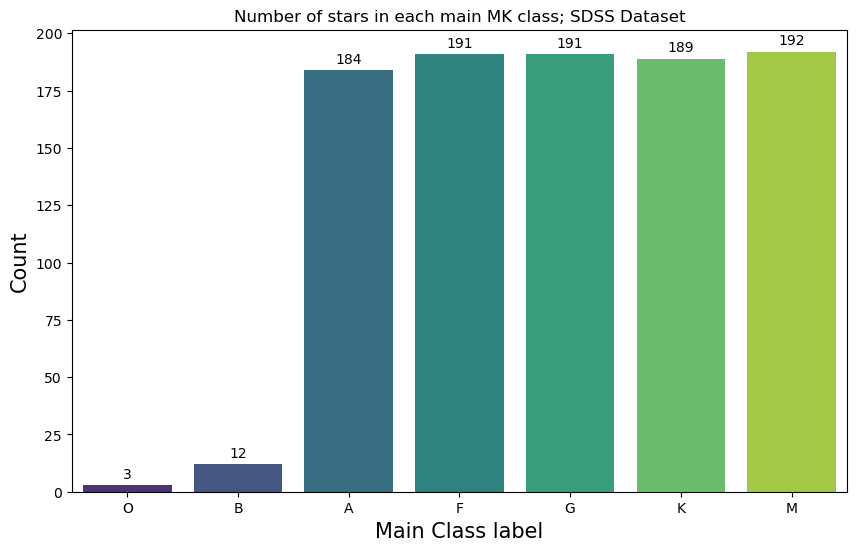

In [45]:
#plotting the distribution of MK classes in SDSS dataset
plt.figure(figsize=(10, 6))
ax =  sns.countplot(x='mainclass', data=stars_df, palette='viridis')
plt.title('Number of stars in each main MK class; SDSS Dataset')
plt.xlabel('Main Class label', fontsize = 15)
plt.ylabel('Count', fontsize= 15)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

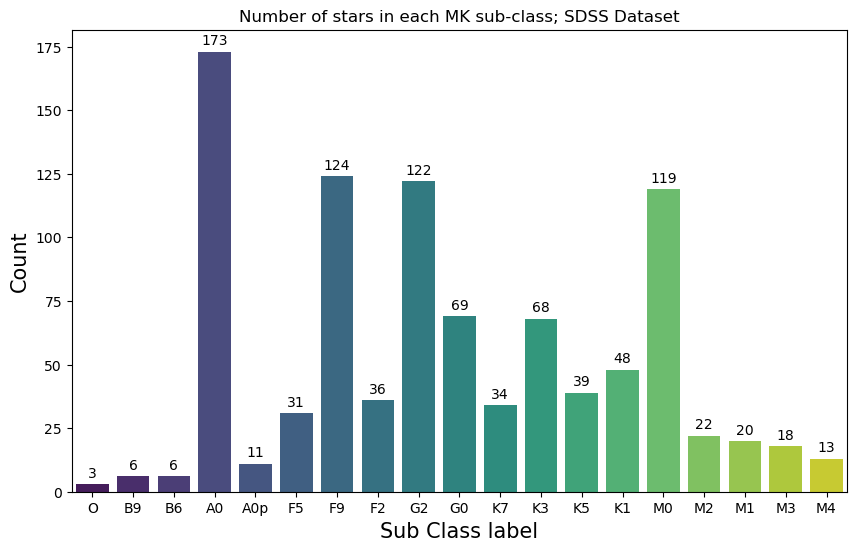

In [47]:
#plotting the distribution of MK classes in SDSS dataset
plt.figure(figsize=(10, 6))
ax =  sns.countplot(x='subclass', data=stars_df, palette='viridis')
plt.title('Number of stars in each MK sub-class; SDSS Dataset')
plt.xlabel('Sub Class label', fontsize = 15)
plt.ylabel('Count', fontsize= 15)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

In [53]:
#getting the common wavelength values
wavelengths= next(iter(spectra_dataframes.items()))[1].wavelength

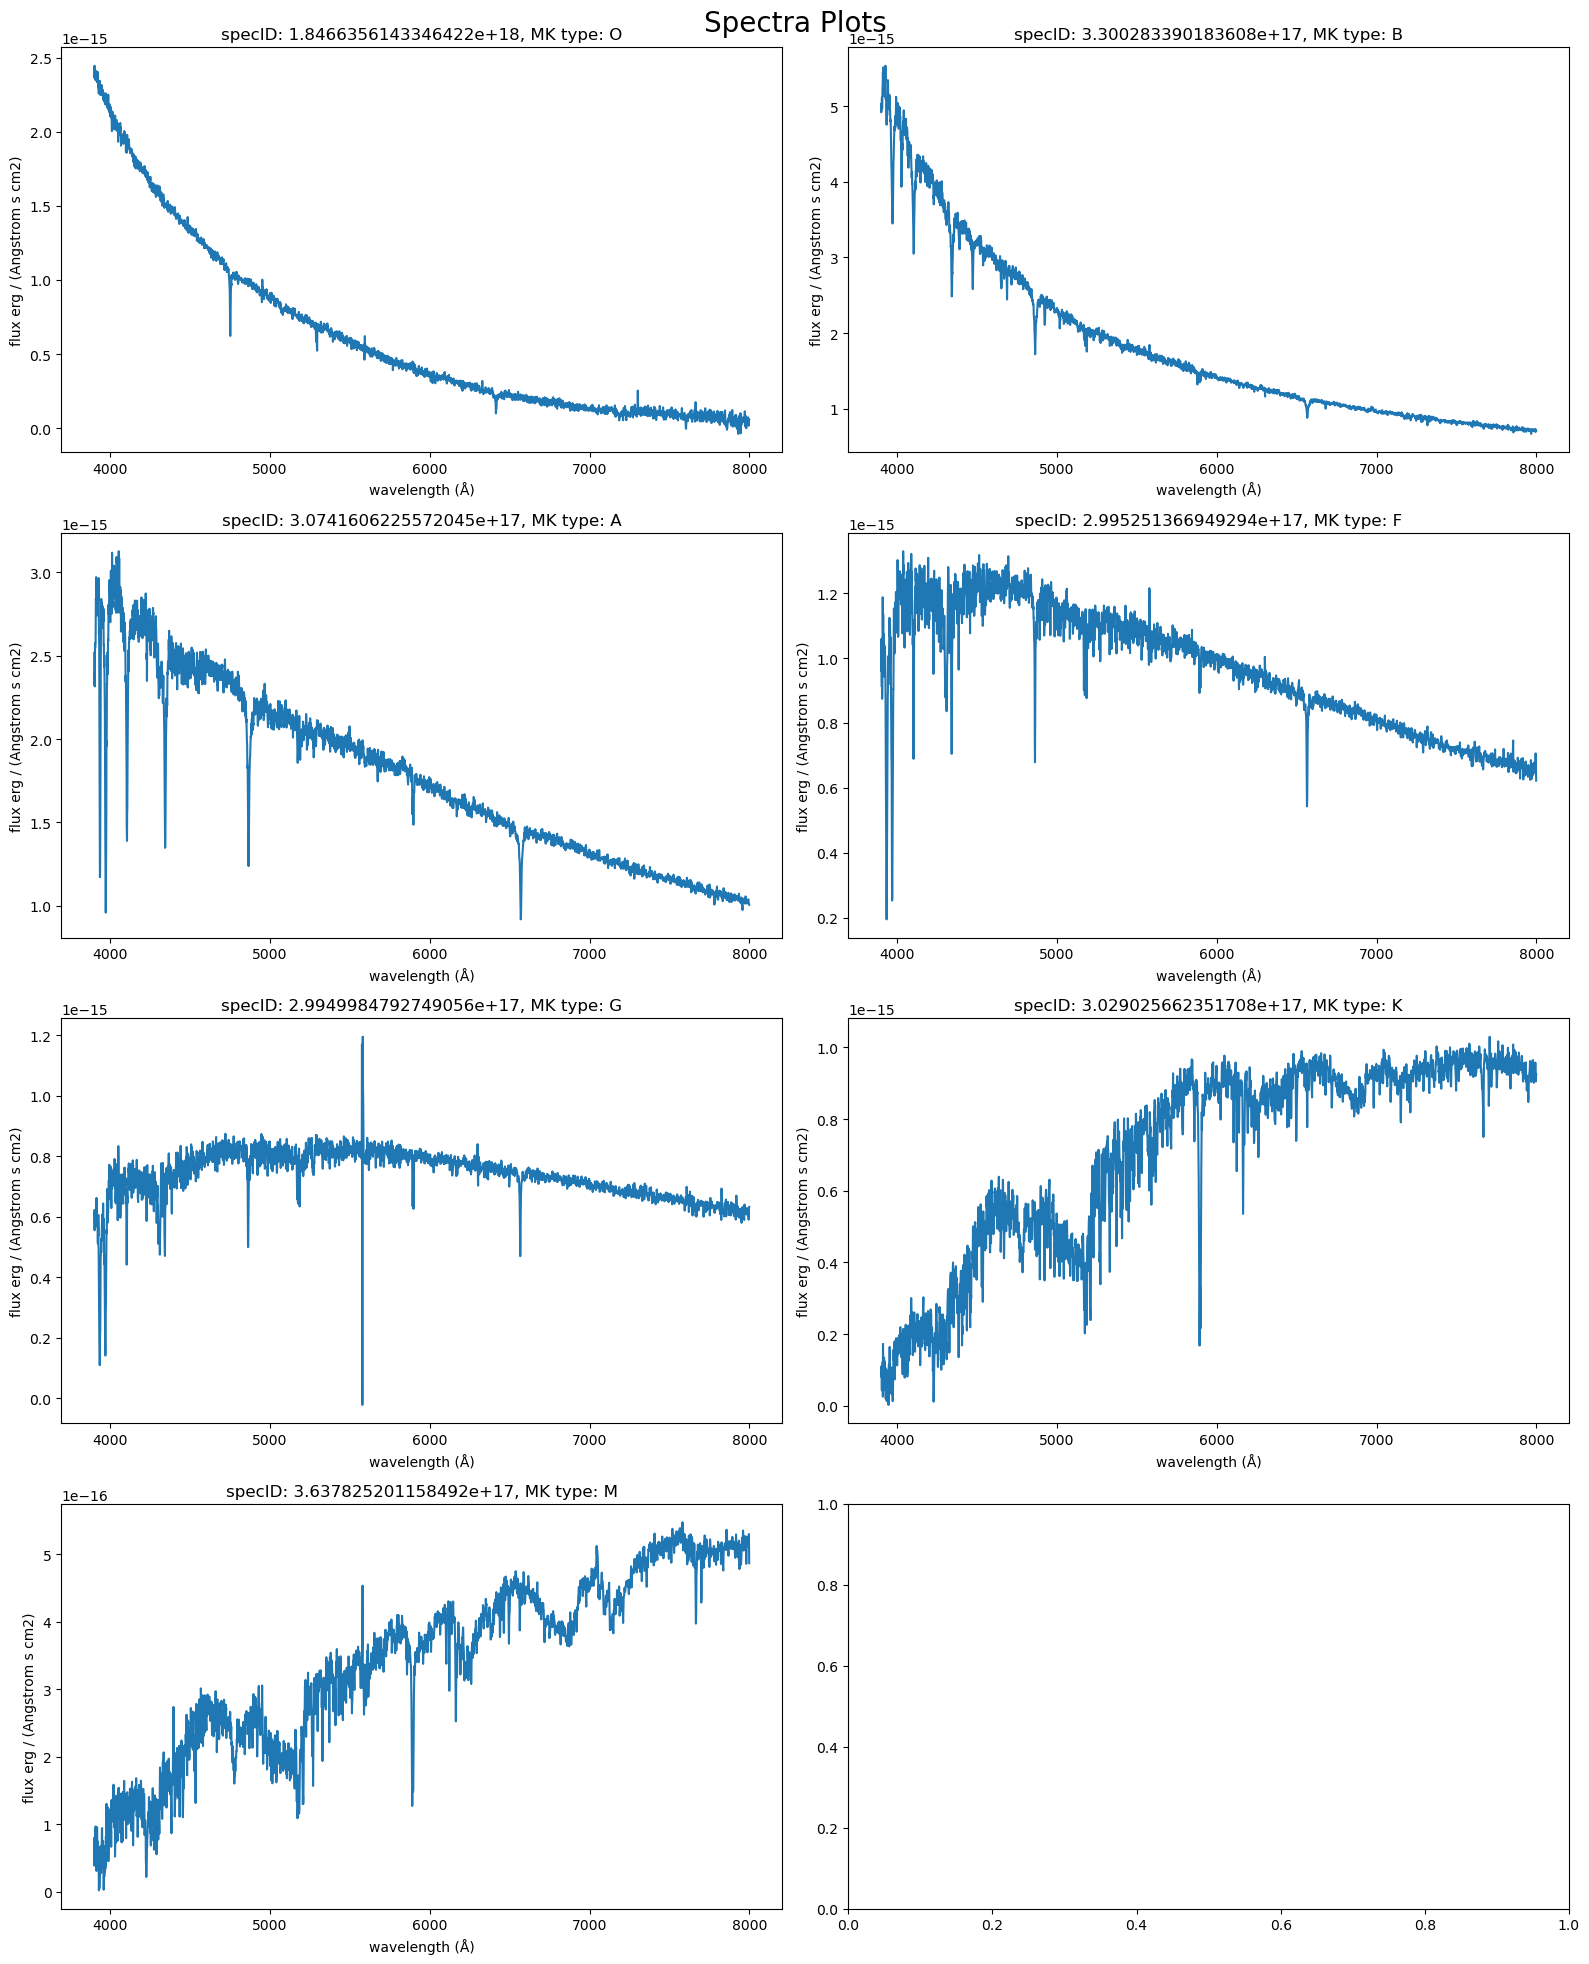

In [52]:
##looking at spectra shapes for all 7 MK classess
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plot_indices = [0,0,1,1,2,2,3]

for i, sp_type in enumerate(['O', 'B', 'A','F','G','K','M']):
    
    #selecting one star from each main class
    params = stars_df[stars_df['mainclass']==sp_type].reset_index().iloc[0]
    spec_id = params.specobjid
    spec_type = params.mainclass
    flux = params.flux
    
    #determining what axes to plot
    #(using mod, means that the first plot will be axes[0, 0], second [0, 1], third [1, 0 ] and so on)
    b = (i + 2) % 2
    a = plot_indices[i]

    sns.lineplot(x=wavelengths, y=flux, ax=axes[a, b])
    axes[a, b].set_title(f'specID: {spec_id}, MK type: {spec_type}')
    flux_units= u.Unit('erg cm-2 s-1 AA-1')
    axes[a, b].set_xlabel('wavelength (Å)')
    axes[a, b].set_ylabel(f'flux {flux_units}')
    
plt.suptitle('Spectra Plots', fontsize=20)
plt.tight_layout()
plt.show() 

## 5. saving SDSS data

In [54]:
#saving as pickle file
stars_df.to_pickle('../data/derived_tables/sdss_data.pkl')

In [55]:
#getting the list of wavelengths and saving as csv
wavelengths= next(iter(spectra_dataframes.items()))[1].wavelength
wavelengths.to_csv('../data/derived_tables/sdss_wave.csv')